# DynMod, Model Analysis cases

#### Bernt Lie, University College of Southeast Norway

### Basic import and definitions

In [1]:
from OMPython import ModelicaSystem
import numpy as np
import numpy.random as nr
%matplotlib inline
%config InlineBackend.figure_formats={'svg',}  # use high quality SVG instead of PNGs
import matplotlib.pyplot as plt
import pandas as pd
LW1 = 2.5
LW2 = LW1/2
Cb1 = (0.3,0.3,1)
Cb2 = (0.7,0.7,1)
Cg1 = (0,0.6,0)
Cg2 = (0.5,0.8,0.5)
Cr1 = "Red"
Cr2 = (1,0.5,0.5)
LS1 = "solid"
LS2 = "dotted"
figpath = "../figs/"
####
case = "ModelAnalysisCases"
####
%mkdir $case # create a subfolder for this case
%cd $case

/home/dietmarw/.workspace/FM1015/ModelAnalysisCases


### Damped linear oscillator: ODE vs. analytic

#### Modelica code, file LinearOscillator

In [2]:
%%writefile LinearOscillator.mo
package LinearOscillator
  // Package for simulating linear oscillator
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			November 10, 2015
  //			May 15, 2017
  //
  model SimLinearOscillator
    // Simulation of linear oscillator
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			November 10, 2015
	//			May 15, 2017
	//
	// Instantiate model of linear oscillator (mlo)
	ModLinearOscillator mlo0, mlo1(Zeta=0), mlo2(Zeta=0), mlo3(Zeta=0);
	// Declaring variables
	// -- inputs
	Real _u0, _u1, _u2, _u3 "Input signal";
	parameter Real w[3] = {0.9*mlo0.w0,mlo0.w0,1.1*mlo0.w0};
	// -- outputs
	output Real _y0, _y1, _y2, _y3 "Output";
	output Real _y0a, _y1a, _y2a, _y3a "Analytically computed output";
  // Equations
  equation
    // -- input values
	_u0 = 0;
	_u1 = 0.1*sin(w[1]*time);
	_u2 = 0.1*sin(w[2]*time);
	_u3 = 0.1*sin(w[3]*time);
	// -- injecting input functions to model inputs
	mlo0.u = _u0; 
	mlo1.u = _u1;
	mlo2.u = _u2;
	mlo3.u = _u3; 
	// -- outputs
	_y0 = mlo0.x[1]; 
	_y1 = mlo1.x[1];
	_y2 = mlo2.x[1];
	_y3 = mlo3.x[1]; 
	_y0a = AModLinearOscillator(t=time,w0=mlo0.w0,Zeta=mlo0.Zeta,y0=1,ua=0,w=0);
	_y1a = AModLinearOscillator(t=time,w0=mlo0.w0,Zeta=mlo1.Zeta,y0=1,ua=0.1,w=0.9*mlo0.w0);
	_y2a = AModLinearOscillator(t=time,w0=mlo0.w0,Zeta=mlo2.Zeta,y0=1,ua=0.1,w=mlo0.w0);
	_y3a = AModLinearOscillator(t=time,w0=mlo0.w0,Zeta=mlo3.Zeta,y0=1,ua=0.1,w=1.1*mlo0.w0);
  end SimLinearOscillator;
  //
  model ModLinearOscillator
    // Model of linear oscillator
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			November 6, 2015
	//			May 15, 2017
	//
	// Parameters
	parameter Real Zeta = 0.3 "Damping factor, -";
	parameter Real w0 = 0.2 "Natural frequency";
	// Initial state parameters
	parameter Real x0[2] = {1,0};
	// Declaring variables
	// -- states
	Real x[2] "Initial state";
	// -- input variables
	input Real u "Input signal";
  // Equations constituting the model
  initial equation
	x = x0;
  equation
	// Differential equations
	der(x) = {x[2],-w0^2*x[1] - 2*Zeta*w0*x[2] + u};
  end ModLinearOscillator;
  //
  function AModLinearOscillator "Analytic solution of linear oscillator"
    // Function for computing analytic solution of linear oscillator
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			November 10, 2015
	//
	// Function input arguments
	input Real t "time, s";
	input Real w0 "resonance frequency";
	input Real Zeta "damping";
	input Real y0 "initial output";
	input Real ua "amplitude of input";
	input Real w = 0 "excitation frequency";
	// Function output response value
	output Real y;
	// Hidden, internal variables
  protected
    parameter Real a = -Zeta*w0;
	parameter Real b = sqrt(1-Zeta^2)*w0;
	Real y_y0;
	Real y_u;
  // Algorithm for computing function value
  algorithm
    y_y0 := -exp(a*t)*(a*sin(b*t)-b*cos(b*t))*y0/b;
	if w == 0 then 
	  y_u := (1-exp(a*t)*(b*cos(b*t)-a*sin(b*t))/b)/(a^2+b^2)*ua;
	else
	  if (Zeta == 0) and (w == w0) then
	    y_u := (sin(w0*t) - w0*t*cos(w0*t))*ua/2/w0^2;
	  else
	    y_u := ((w0^2-w^2)*sin(w*t) + 2*a*w*cos(w*t))*ua/((w0^2+w^2)^2-4*b^2*w^2)
	        + w*exp(a*t)/b*((a^2-b^2+w^2)*sin(b*t)-2*a*b*cos(b*t))*ua/((w0^2+w^2)^2-4*b^2*w^2);
      end if;
	end if;
    y := y_y0 + y_u;
  end AModLinearOscillator;
  // End package
end LinearOscillator;

Writing LinearOscillator.mo


#### Instantiating model from ModLinearOscillator

In [3]:
lo = ModelicaSystem("LinearOscillator.mo","LinearOscillator.SimLinearOscillator")

2017-08-07 17:27:30,777 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.235f20234ef0453d9ed0f823290586af


In [4]:
lo.setSimulationOptions(stopTime=600,stepSize=1.5)

In [5]:
lo.simulate()

In [6]:
tm,y0,y0a = lo.getSolutions("time","_y0","_y0a")

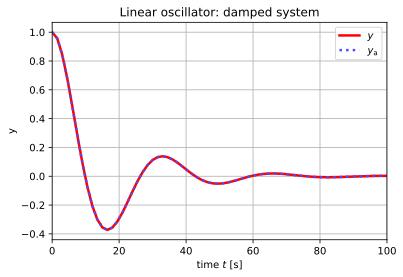

In [7]:
plt.plot(tm,y0,linewidth=LW1,color=Cr1,label=r"$y$")
plt.plot(tm,y0a,linewidth=LW1,color=Cb1,linestyle=LS2,label=r"$y_\mathrm{a}$")
plt.title(r"Linear oscillator: damped system")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"y")
plt.legend()
plt.grid()
plt.xlim(0,100)
figfile = "LinearOscillatorSim-1.pdf"
plt.savefig(figpath+figfile)

In [8]:
y1,y2,y3 = lo.getSolutions("_y1","_y2","_y3")

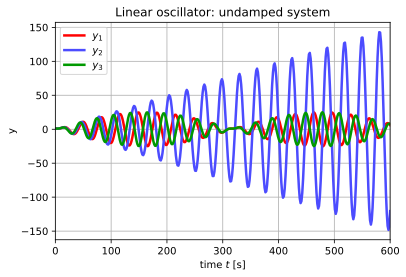

In [9]:
plt.plot(tm,y1,linewidth=LW1,color=Cr1,label=r"$y_1$")
plt.plot(tm,y2,linewidth=LW1,color=Cb1,label=r"$y_2$")
plt.plot(tm,y3,linewidth=LW1,color=Cg1,label=r"$y_3$")
plt.title(r"Linear oscillator: undamped system")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"y")
plt.legend()
plt.grid()
plt.xlim(0,600)
figfile = "LinearOscillatorSim-2.pdf"
plt.savefig(figpath+figfile)